# Zestaw 7. Iteracyjne rozwiązywanie układów liniowych

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import networkx as nx

## 1. Metody stacjonarne

<i>Zaimplementuj metody Jacobiego, Gaussa-Seidla i SOR. Użyj ich do rozwiązania poniższych układów równań z dokładnością do 4 miejsc znaczących.</i>

Przywołane metody iteracyjne mają szansę zadziałać tylko dla macierzy, której wszystkie elementy na przekątnej są niezerowe. Każdą macierz główną układu, który da się rozwiązać, jesteśmy w stanie doprowadzić do takiej postaci poprzez zamianę kolejności wierszy/kolumn.

In [109]:
def non_zero_diagonal(A, B):
    n = A.shape[0]
    i = 0
    while not np.all(np.diag(A) != 0) and i < A.shape[0]:
        zeros_columns = {}
        for i in range(n):
            if A[i][i] != 0: continue
            zeros_count = 0
            for j in range(n):
                if A[i][j] == 0:
                    zeros_count += 1
            
            zeros_columns[i] = zeros_count
        
        max_column = max(zeros_columns, key = zeros_columns.get)
        max_element_row = np.where(A[:, max_column] == max(A[:, max_column]))[0][0]

        A[[max_element_row, max_column]] = A[[max_column, max_element_row]]
        B[[max_element_row, max_column]] = B[[max_column, max_element_row]]
        i += 1
            
    return A, B

Z twierdzenia o zbieżności procesu iteracyjnego, aby proces był zbieżny, promień spektralny macierzy iteracji musi być mniejszy od 1. Promień spektralny jest równy maksymalnej wartości bezwględnej z wartości własnych macierzy.

In [110]:
def spectral_radius(A):
    eigvals = np.linalg.eigvals(A)
    return abs(max(eigvals, key=abs))

W implementacji trzech metod iteracyjnych skorzystałem z operacji na macierzach.

#### metoda Jacobiego

In [111]:
def jacobi(A, B, x0, exact, precision=1e-4):
    n = A.shape[0]
    
    A, B = non_zero_diagonal(A, B)
    
    x = x0
    D = np.diag(np.diag(A))
    inv_D = np.diag(1/np.diag(A))
    M = np.eye(n) - inv_D @ A   
    W = inv_D @ B
    
    radius = spectral_radius(M)
    if radius >= 1:
        raise Exception(f'spectral radius ({radius}) is not less than 1')
    
    errors = []
    i = 0
    
    while not np.allclose(x, exact, atol=precision):
        errors.append(np.mean((abs(exact-x))))
        x  = M @ x + W
        i += 1
        
        if i > 5000:
            raise Exception('iterations limit exceeded')
    
    errors.append(np.mean((abs(exact-x))))
    return i, x, errors, radius

#### metoda Gaussa-Seidla

In [112]:
def gauss_seidl(A, B, x0, exact, precision=1e-4):
    n = A.shape[0]
    
    A, B = non_zero_diagonal(A, B)
    
    x = x0
    L = np.tril(A)
    
    U = np.triu(A) - np.diag(np.diag(A))
    M = -inv(L) @ U
    W = inv(L) @ B
    
    radius = spectral_radius(M)
    if radius >= 1:
        raise Exception(f'spectral radius ({radius}) is not less than 1')
    
    errors = []
    i = 0
    
    while not np.allclose(x, exact, atol=precision):
        errors.append(np.mean((abs(exact-x))))
        x  = M @ x + W
        i += 1
        
        if i > 5000:
            raise Exception('iterations limit exceeded')
    
    errors.append(np.mean((abs(exact-x))))                  
    return i, x, errors, radius

#### metoda SOR

In [113]:
def sor(A, B, x0, exact, omega, precision=1e-4):
    n = A.shape[0]
    
    A, B = non_zero_diagonal(A, B)
    
    x = x0
    D = np.diag(np.diag(A))
    L = np.tril(A) - D
    U = np.triu(A) - D
    M = inv(D + omega*L) @ (D - omega*(D + U))
    W = omega * inv(D + omega*L) @ B
    
    radius = spectral_radius(M)
    if radius >= 1:
        raise Exception(f'spectral radius ({radius}) is not less than 1')
    
    i = 0
    errors = []
    
    while not np.allclose(x, exact, atol=precision):
        errors.append(np.mean((abs(exact-x))))
        x  = M @ x + W
        
        i += 1
        if i > 5000:
            raise Exception('iterations limit exceeded')
    
    errors.append(np.mean((abs(exact-x))))
    
    return i, x, errors, radius

W powyższej implementacji zadanych metod (Gaussa-Seidla i SOR), skorzystałem z funkcji numpy.linalg.inv do znalezienia macierzy odwrotnej. Z założenia, w metodach iteracyjnych dobieramy takie macierze, aby policzenie odwrotności było proste. Zdecydowałem się na użycie funkcji bibliotecznej, gdyż przypuszczam, iż funkcja ta jest zoptymalizowana kątem szczególnych typów macierzy i korzystając z niej, nie zwiększę w szczególny sposób błędu.

#### testy

In [114]:
A1 = np.array([[7, 1, -1, 2], [1, 8, 0, -2],[-1, 0, 4, -1], [2, -2, -1, 6]])
B1 = np.array([3, -5, 4, -3])
x01 = np.zeros(4)
omega1 = 1.1
exact1 = np.array([1, -1, 1, -1])

In [115]:
A2 = np.array([[7, 3, -1, 2], [3, 8, 1, -4],[-1, 1, 4, -1], [2, -4, -1, 6]])
B2 = np.array([-1, 0, -3, 1])
x02 = np.zeros(4)
omega2 = 1.4
exact2 = np.array([-1, 1, -1, 1])

In [116]:
def test_solve(A, B, x0, exact, omega):
    jacobi_res = jacobi(A, B, x0, exact)
    gauss_seidl_res = gauss_seidl(A, B, x0, exact)
    sor_res = sor(A, B, x0, exact, omega)
    

    print(f"\n--JACOBI--\n\titerations: {jacobi_res[0]} | result: {jacobi_res[1]}")
    print('\tspectral radius:\n', jacobi_res[3])
    print(f"--GAUSS-SEIDL--\n\titerations: {gauss_seidl_res[0]} | result: {gauss_seidl_res[1]}")
    print('\tspectral radius:\n', gauss_seidl_res[3])
    print(f"--SOR--\n\titerations: {sor_res[0]} | result: {sor_res[1]}")
    print('\tspectral radius:\n', sor_res[3])

In [117]:
test_solve(A1, B1, x01, exact1, omega1)


--JACOBI--
	iterations: 14 | result: [ 0.99995716 -0.99995716  1.00000235 -0.99992703]
	spectral radius:
 0.4966500211811145
--GAUSS-SEIDL--
	iterations: 7 | result: [ 0.99989203 -0.99991255  1.00004696 -0.99992703]
	spectral radius:
 0.24666124353920096
--SOR--
	iterations: 5 | result: [ 1.00002942 -1.00002682  0.99996387 -1.00000953]
	spectral radius:
 0.10000000000000009


In [118]:
test_solve(A2, B2, x02, exact2, omega2)


--JACOBI--
	iterations: 71 | result: [-0.99991675  0.99990401 -0.99997751  0.99989967]
	spectral radius:
 0.8770907658496181
--GAUSS-SEIDL--
	iterations: 36 | result: [-0.99990588  0.99990014 -0.99998236  0.999905  ]
	spectral radius:
 0.7698961627782164
--SOR--
	iterations: 11 | result: [-1.00007883  1.00007612 -0.99995452  1.00006055]
	spectral radius:
 0.41711260752444557


#### zależność błędu od liczby iteracji

<i>Zaprezentuj na wykresie zależność błędu od iteracji. Opisz i zinterpretuj wyniki. </i>

In [119]:
def plot_iteration_error(A, B, x0, exact, omega):
    jacobi_errors = jacobi(A, B, x0, exact)[2]
    gauss_seidl_errors = gauss_seidl(A, B, x0, exact)[2]
    sor_errors = sor(A, B, x0, exact, omega)[2]
    
    _, ax = plt.subplots(figsize=(12,8))
    
    ax.set_xlabel('iteration')
    ax.set_ylabel('error')
    
    ax.plot(list(range(len(jacobi_errors))), jacobi_errors, marker='o', label='jacobi', color='rosybrown', markersize=8)
    ax.plot(list(range(len(gauss_seidl_errors))), gauss_seidl_errors, marker='o', label='gauss-seidl', color='lightskyblue', markersize=8)
    ax.plot(list(range(len(sor_errors))), sor_errors, marker='o', label='sor', color='mediumaquamarine', markersize=8)
    
    plt.legend()
    plt.show()

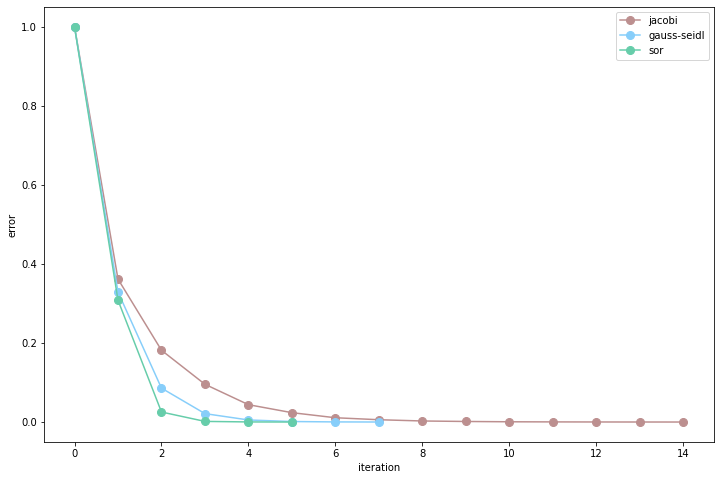

In [120]:
plot_iteration_error(A1, B1, x01, exact1, omega1)

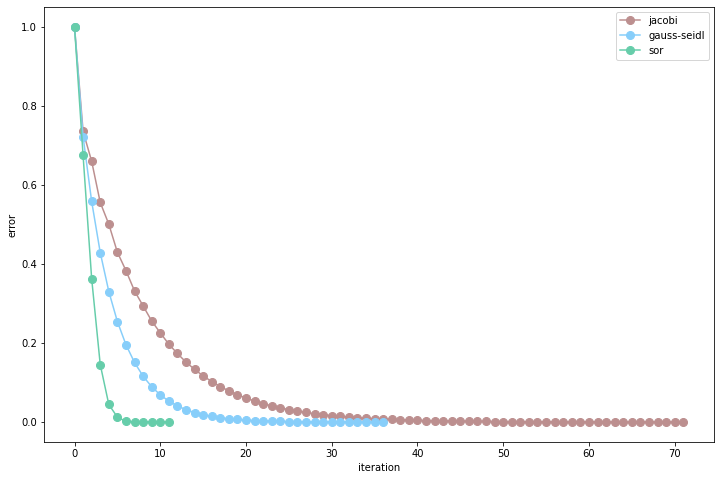

In [121]:
plot_iteration_error(A2, B2, x02, exact2, omega2)

Dla obydwu przypadków wszystkie metody poprawnie odnalazły rozwiązanie układu z zadaną dokładnością. Dla obydwu układów najszybciej zbiegająca okazała się metoda SOR, nieco wolniejsza była metoda Gaussa-Seidla, a najwolniej zbiegała metoda Jacobiego. Skuteczność metody SOR wynika jednak z doboru omegi, która była podana. Przyjmując omega=1 metoda SOR jest równoważna metodzie Gaussa-Seidla, jednak dobierając korzystną wartość omega, jesteśmy w stanie przyspieszyć procedurę.

Wyraźnie widać, iż wyniki otrzymane dla drugiej macierzy są gorsze niż te dla pierwszej; wszystkie metody potrzebowały większej liczby iteracji do osiagnięcia zamierzonej dokładności. Wynika to z natury zadanej macierzy oraz parametrów wybranej macierzy iteracji, a konkretnie jej promienia spektralnego. Jak można zauważyć, im mniejsza wartość promienia, tym szybciej metoda zbiega do poprawnej wartości. 

We wszystkich przypadkach promień spektralny był mniejszy od 1, co pozwoliło uzyskać poprawny wynik, jednak konkretna wartość różniła się, co wpłynęło na liczbę potrzebnych iteracji.

## 2. Analiza obwodu elektrycznego

<i> Wykorzystaj dowolną z powyższych metod do wyliczenia natężenia prądu w każdej z części obwodu elektrycznego. <br><br>
a) Stwórz funkcję tworzącą graf opisujący obwód elektryczny. Argumentami tej funkcji są:

* Lista krawędzi grafu ważonego gdzie wagi krawędzi określają opór fragmentu obwodu między dwoma węzłami. Wierzchołki grafu identyfikowane są przez liczby naturalne.
* Trójka liczb (s, t, E), przy czym para (s, t) wskazuje między którymi węzłami sieci przyłożono siłę elektromotoryczną E. Opór wewnętrzny SEM można zaniedbać. </i>

In [122]:
def create_circuit(resistors, emf):
    graph = nx.DiGraph()
    
    for a, b, resistance in resistors:
        graph.add_edge(a, b, weight=resistance)
        
    a, b, weight = emf
    if (a, b) not in graph.edges() and (b, a) not in graph.edges():
        graph.add_edge(a, b, weight=0)
    
    return graph

In [148]:
def draw_graph(graph, pos=None):
    if pos is None:
        pos=nx.circular_layout(graph)
        
    nx.draw_networkx(graph, pos, with_labels=True, node_color='cadetblue')
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=labels)

<i>b) Napisz funkcję, która wykorzystując prawa Kirchhoffa znajdzie natężenia prądu w każdej części obwodu i przedstawi je na rysunku w postaci grafu ważonego z etykietami. </i>

In [149]:
def get_amperage(graph, a, b, voltage, exact=None):
    n = graph.number_of_edges()
    A = np.zeros((n, n))
    B = np.zeros(n)

    edges = {x: i for i, x in enumerate(graph.edges())}
    
    row = 0
    
    # Drugie Prawo Kirchhoffa
    for cycle in nx.cycle_basis(graph.to_undirected()):
        for j in range(len(cycle)):
            v1, v2 = cycle[j-1], cycle[j]
            
            # opór elektryczny
            if (v1, v2) in edges:
                A[row][edges[v1, v2]] = graph[v1][v2]['weight']
            else:
                A[row][edges[v2, v1]] = -graph[v2][v1]['weight']
                
            # siła elektromotoryczna ogniwa
            if (v1, v2) == (a, b):
                B[row] = voltage
            elif (v1, v2) == (b, a):
                B[row] = -voltage
                
        row += 1
    
    rows_start = row
        
    # Pierwsze Prawo Kirchhoffa
    for row in range(rows_start, n):
        v1 = row - rows_start
        for v2 in graph[v1]:
            A[row][edges[v1, v2]] = 1
        for v2, _ in graph.in_edges(v1):
            A[row][edges[v2, v1]] = -1
    

    if exact is None:
        exact = np.linalg.solve(A, B)
    
    try:
        x = gauss_seidl(A, B, np.zeros(len(edges)), exact, precision=0.5)
    except Exception as ex:
        print(ex)
        x = exact
    
    new_graph = nx.DiGraph()
    
    for edge, i in edges.items():
        a, b = (edge[0], edge[1]) if x[i] > 0 else (edge[1], edge[0])
        new_graph.add_edge(a, b, weight=round(abs(x[i]), 2))
    
    return new_graph

<i>c) Przetestuj działanie metody dla obwodu przedstawionego na Rysunku 1, wiedząc, że poprawne rozwiązanie to $x_1 = 26.5, x_2 = 9.35, x_3 = 13.3, x_4 = 6.13$ </i>

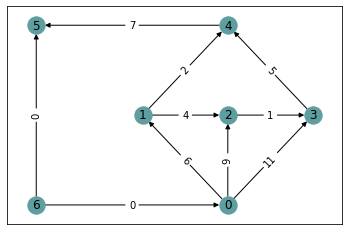

In [150]:
resistors = [(0, 1, 6), (0, 2, 9), (0, 3, 11), 
             (1, 2, 4), (1, 4, 2), (2, 3, 1), (3, 4, 5),
             (4, 5, 7), (6, 0, 0)]

emf = (6, 5, 300)

pos = {0: (10, 1), 1: (6, 5), 2: (10, 5), 3: (14, 5), 4: (10, 9), 5: (1, 9), 6:(1, 1)}

g = create_circuit(resistors, emf)
draw_graph(g, pos)

Singular matrix


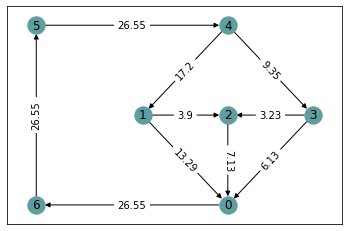

In [151]:
result_graph = get_amperage(g, *emf)
draw_graph(result_graph, pos)

<i>d) Przedstaw (wizualizacja oraz sprawdzenie poprawności wyników) działanie programu dla grafów spójnych mających od 15 do 100 wierzchołków: </i>
    

* Spójny graf losowy

* Graf 3-regularny (kubiczny)

* Graf złożony z dwóch grafów losowych połączonych mostkiem

* Graf siatka 2D

## Wnioski

 - 
 - 
 -

M. Hawryluk 29.04.2021